In [2]:
from streaming_gmm import lightcurve
import matplotlib.pyplot as plt
import numpy as np
import logging


%matplotlib inline
%load_ext autoreload
%autoreload 2

LC_PATH = 'data/lc_1.3444.614.B.mjd'

## Batch experiment

In the following cells we load an Eclipsing Binary, so we can calculate
its period.

In [3]:
lightcurve_df = lightcurve.read_from_file(LC_PATH, skiprows=3)
lightcurve_df = lightcurve.remove_unreliable_observations(lightcurve_df)
time, mag, error = lightcurve.unpack_df_in_arrays(lightcurve_df)

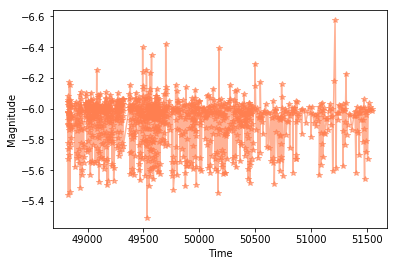

In [4]:
color = [1 ,0.498039, 0.313725]
p = plt.plot(time, mag, '*-', color=color, alpha = 0.6)
plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.gca().invert_yaxis()

In [5]:
def plot_folded_lightcurve(time, mag, period):
    color = [ 0.392157, 0.584314 ,0.929412]
    T = 2 * period
    new_b=np.mod(time, period) / period
    idx=np.argsort(2 * new_b)
    plt.plot(new_b, mag, '*', color=color)
    plt.xlabel("Phase")
    plt.ylabel("Magnitude")
    plt.gca().invert_yaxis()

### Gatspy LombScargle

In the cell below we calculate the periodogram of the lightcurve using
the `gatspy` Lomb-Scargle algorithm. The idea is to compare this result
to the streaming LS in batch setting for verification that the implementation
is correct.

Most probable period: 0.93697445905


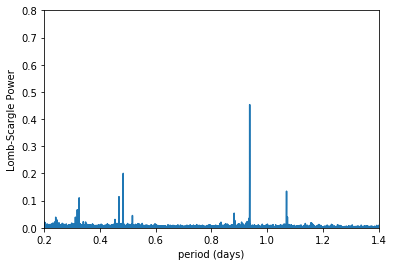

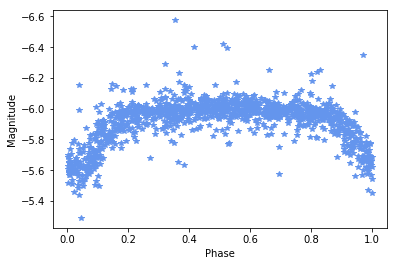

In [6]:
from gatspy.periodic import LombScargleFast

model = LombScargleFast().fit(time, mag, error)
periods, power = model.periodogram_auto(nyquist_factor=100)
period = periods[np.argmax(power)]
print('Most probable period:', period)

plt.plot(periods, power)
plt.xlim((0.2, 1.4))
plt.ylim((0, 0.8))
plt.xlabel('period (days)')
plt.ylabel('Lomb-Scargle Power')
plt.show()

plot_folded_lightcurve(time, mag, period)

### Batch Bayesian GLS implementation

In the cell below we compute the periodogram and period using the bayesian
generalized LS algorithm that I implemented. We should see the same period.

Most probable period: 0.937169928064


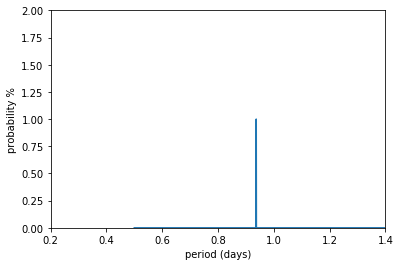

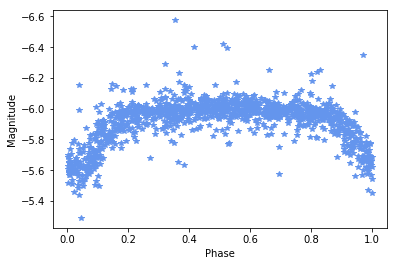

In [7]:
from streaming_gmm.streaming_features import StreamingBGLS

model = StreamingBGLS(freq_multiplier=100)
model.update(time, mag, error)
periods, probability = model.periodogram()
print('Most probable period:', model.most_probable_period())

plt.plot(periods, probability)
plt.xlim((0.2, 1.4))
plt.ylim((0, 2))
plt.xlabel('period (days)')
plt.ylabel('probability %')
plt.show()

plot_folded_lightcurve(time, mag, period)

## Streaming experiment

In [8]:
import time as tm

### Bayesian Lomb-Scargle

In [9]:
from streaming_gmm.streaming_lightcurve import to_chunks

model = StreamingBGLS(freq_multiplier=100)

bgls_batch_times = []

start_time_sec = tm.time()
for time, mag, error in to_chunks(lightcurve_df):
    batch_start_time_sec = tm.time()
    model.update(time, mag, error)
    periods, probability = model.periodogram()
    batch_elapsed_time_sec = tm.time() - batch_start_time_sec
    bgls_batch_times.append(batch_elapsed_time_sec)
    print('Most probable period:', model.most_probable_period())
    print('Batch elapsed time:', batch_elapsed_time_sec, 'secs')
elapsed_time_sec = tm.time() - start_time_sec
print('Total time for lightcurve:', elapsed_time_sec, 'secs')

Most probable period: 0.683131059115
Batch elapsed time: 0.02073073387145996 secs
Most probable period: 0.936587498634
Batch elapsed time: 0.03162884712219238 secs
Most probable period: 0.936587498634
Batch elapsed time: 0.0483393669128418 secs
Most probable period: 0.936587498634
Batch elapsed time: 0.06672906875610352 secs
Most probable period: 0.937169928064
Batch elapsed time: 0.0745236873626709 secs
Most probable period: 0.937169928064
Batch elapsed time: 0.0851283073425293 secs
Most probable period: 0.937169928064
Batch elapsed time: 0.08765339851379395 secs
Most probable period: 0.937169928064
Batch elapsed time: 0.1030428409576416 secs
Most probable period: 0.937169928064
Batch elapsed time: 0.11824893951416016 secs
Most probable period: 0.937169928064
Batch elapsed time: 0.13242650032043457 secs
Most probable period: 0.937169928064
Batch elapsed time: 0.13657808303833008 secs
Most probable period: 0.937169928064
Batch elapsed time: 0.1547555923461914 secs
Most probable period:

In [10]:
model = LombScargleFast()

accum_time = None
accum_mag = None
accum_error = None

n_chunks = 0
gatspy_elapsed_time = []

start_time_sec = tm.time()
for time, mag, error in to_chunks(lightcurve_df):
    if n_chunks == 0:
        accum_time = time
        accum_mag = mag
        accum_error = error
    else:
        accum_time = np.concatenate((accum_time, time))
        accum_mag = np.concatenate((accum_mag, mag))
        accum_error = np.concatenate((accum_error, error))
    batch_start_time_sec = tm.time()
    model.fit(accum_time, accum_mag, accum_error)
    periods, power = model.periodogram_auto(nyquist_factor=100)
    period = periods[np.argmax(power)]
    batch_elapsed_time_sec = tm.time() - batch_start_time_sec
    print('Most probable period:', period)
    print('Batch elapsed time:', batch_elapsed_time_sec, 'secs')
    n_chunks += 1
elapsed_time_sec = tm.time() - start_time_sec
print('Total time for lightcurve:', elapsed_time_sec, 'secs')

Most probable period: 0.406074926764
Batch elapsed time: 0.025894880294799805 secs
Most probable period: 0.936494166667
Batch elapsed time: 0.06267976760864258 secs
Most probable period: 0.936184345291
Batch elapsed time: 0.10761761665344238 secs
Most probable period: 0.937007391775
Batch elapsed time: 0.10631680488586426 secs
Most probable period: 0.937187355201
Batch elapsed time: 0.20750832557678223 secs
Most probable period: 0.937218442211
Batch elapsed time: 0.22347474098205566 secs
Most probable period: 0.937098343158
Batch elapsed time: 0.22404098510742188 secs
Most probable period: 0.937087651693
Batch elapsed time: 0.23876571655273438 secs
Most probable period: 0.936758854075
Batch elapsed time: 0.4926297664642334 secs
Most probable period: 0.936919177215
Batch elapsed time: 0.4402003288269043 secs
Most probable period: 0.936949980935
Batch elapsed time: 0.621720552444458 secs
Most probable period: 0.936989885293
Batch elapsed time: 0.4637014865875244 secs
Most probable period